# SincNet

뉴럴네트워크 기반 피처 추출 기법 가운데 하나인 SincNet 모델을 살펴봅니다. SincNet은 벤지오 연구팀이 2018년 발표한 [SPEAKER RECOGNITION FROM RAW WAVEFORM WITH SINCNET](https://arxiv.org/pdf/1812.05920) 논문에서 제안됐는데요. 음성 피처 추출에 유리한 컨볼루션 신경망(Convolutional Neural Network)의 첫번째 레이어에 싱크 함수(sinc function)를 도입해 계산 효율성과 성능 두 마리 토끼를 잡아서 주목받았습니다.

---


## 모델 개요

SincNet 모델 개요는 다음과 같습니다. 저자들은 음성 피처 추출에 첫번째 레이어가 가장 중요하다고 보고 해당 레이어에 `싱크 함수(sinc function)`로 컨볼루션 필터를 만들었습니다. 이들 필터들은 원래 음성(raw waveform)에서 태스크 수행에 중요한 주파수 영역대 정보를 추출해 상위 레이어로 보냅니다. 

## **그림1** sincnet 
<img src="https://i.imgur.com/n1EXsWV.png" width="400px" title="source: imgur.com" />

그 위 레이어들은 여느 뉴럴넷에 있는 구조와 별반 다르지 않고요. 화자(speaker)가 누구(index)인지 맞추는 과정에서 SincNet이 학습됩니다. SincNet 모델을 이해하기 위해서는 `시간(time) 도메인에서의 컨볼루션 연산` 개념을 이해할 필요가 있습니다. 다음 장에서 차례대로 살펴보겠습니다.


---


## 시간 도메인에서의 컨볼루션 연산

시간 도메인에서의 컨볼루션 연산의 정의는 다음 수식1과 같습니다. $x[ n ]$은 시간 도메인에서의 $n$번째 raw wave sample, $h[ n ]$은 컨볼루션 필터(filter, 1D 벡터)의 $n$번째 요소값, $y[ n ]$은 컨볼루션 수행 결과의 $n$번째 값을 각각 가리킵니다. $L$은 필터의 길이(length)를 나타냅니다.


## **수식1** 시간 도메인에 대한 컨볼루션 연산
$$y\left[ n \right] =x\left[ n \right] \ast h\left[ n \right] =\sum _{ l=0 }^{ L-1 }{ x\left[ l \right] \cdot h\left[ n-1 \right]  }$$



예컨대 필터 길이 $L$이 3이라면 수식1에 따라 계산되는 과정은 다음과 같을 겁니다.


## **수식2** 컨볼루션 연산 예시
$$y\left[ 0 \right] =x\left[ 0 \right] \cdot h\left[ 0 \right] \\ y\left[ 1 \right] =x\left[ 0 \right] \cdot h\left[ 1 \right] +x\left[ 1 \right] \cdot h\left[ 0 \right] \\ y\left[ 2 \right] =x\left[ 0 \right] \cdot h\left[ 2 \right] +x\left[ 1 \right] \cdot h\left[ 1 \right] +x\left[ 2 \right] \cdot h\left[ 0 \right] \\ y\left[ 3 \right] =x\left[ 0 \right] \cdot h\left[ 3 \right] +x\left[ 1 \right] \cdot h\left[ 2 \right] +x\left[ 2 \right] \cdot h\left[ 1 \right] $$


이렇게만 보면 정말 알쏭달쏭하죠. 그림으로 이해해 봅시다. 일단 입력 음성 시그널이 그림2, 컨볼루션 필터가 그림3과 같다고 합시다. 

## **그림2** input waveform 예시
<img src="https://i.imgur.com/TNF1k2k.jpg" width="250px" title="source: imgur.com" />

## **그림3** 컨볼루션 필터 예시
<img src="https://i.imgur.com/7Fp6Zn0.jpg" width="250px" title="source: imgur.com" />

컨볼루션 연산은 **컨볼루션 필터를 Y축을 기준으로 뒤집어 필터 $h$와 입력 $x$를 내적(inner product)하는 것과 같습니다.** 그림4를 수식2와 비교해서 보면 정확히 들어맞음을 확인할 수 있습니다.

## **그림4** 컨볼루션 연산 예시
<img src="https://i.imgur.com/AQ8wz1C.jpg" width="350px" title="source: imgur.com" />
<br>
<img src="https://i.imgur.com/x2qYYXw.jpg" width="350px" title="source: imgur.com" />
<br>
<img src="https://i.imgur.com/BL9UK1h.jpg" width="350px" title="source: imgur.com" />

컨볼루션 연산 결과물인 $y$는 입력 시그널 $x$와 그에 곱해진 컨볼루션 필터 $h$와의 관련성이 높을 수록 커집니다. 혹은 특정 입력 시그널을 완전히 무시할 수도 있습니다. 다시 말해 **컨볼루션 필터는 특정 주파수 성분을 입력 신호에서 부각하거나 감쇄시킨다**는 것입니다. 

컨볼루션 연산을 좀 더 직관적으로 이해해 보기 위해 그림5를 봅시다. 예컨대 시간 도메인에 적용되는 컨볼루션 필터가 그림5 하단 중앙처럼 되어 있다고 가정해 봅시다. 지금까지 설명해 드렸던 컨볼루션 연산 과정을 감안하면 이 컨볼루션 필터는 입력 시그널 $x$를 가감 없이 그대로 통과시키게 될 겁니다. 이를 주파수 도메인에서 생각해보면 그림5의 상단처럼 연산이 이뤄집니다. 다시 말해 **시간(time) 도메인에서의 컨볼루션(convolution) 연산은 주파수(frequency) 도메인에서의 곱셈(multiplication) 연산과 동일하다**는 것입니다.

## **그림5** 주파수 도메인의 곱셈 VS 시간 도메인의 컨볼루션 (1)
<img src="https://i.imgur.com/w3ODRrt.jpg" width="400px" title="source: imgur.com" />


또다른 예시를 봅시다. 그림6과 같은 `구형 함수(rectangular function)`를 주파수 도메인에서 입력 신호와 곱하면(multiplication) $f_1$과 $f_2$ 사이의 주파수만 남고 나머지는 없어질 겁니다(그림6의 상단). 이는 시간 도메인에서 싱크 함수(sinc function)으로 입력 신호에 컨볼루션(convolution) 연산을 수행한 결과에 대응합니다(그림6의 하단).


## **그림6** 주파수 도메인의 곱셈 vs 시간 도메인의 컨볼루션 (2)
<img src="https://i.imgur.com/bVDA6Qo.jpg" width="400px" title="source: imgur.com" />


---


## Bandpass Filter : Sinc Function

우리는 음성 신호 $x$ 가운데 화자 인식 등 문제 해결에 도움이 되는 주파수 영역대(band)는 살리고, 나머지 주파수 영역대는 무시하길 원합니다. 이렇게 특정 주파수 영역대만 남기는 역할을 하는 함수를 `bandpass filter`라고 부릅니다. 주파수 도메인에서 이런 역할을 이상적으로 할 수 있는 필터의 모양은 사각형(Rectangular) 모양일 겁니다. 그림7처럼 말이죠.


## **그림7** Bandpass Filter
<img src="https://i.imgur.com/FgzqVBY.jpg" width="400px" title="source: imgur.com" />


이때 싱크 함수라는게 제법 요긴하게 쓰입니다. **주파수(frequency) 도메인에서 구형 함수(Rectangular function)으로 곱셈 연산**을 수행한 결과는 **시간(time) 도메인에서 싱크 함수로 컨볼루션 연산**을 적용한 것과 동치(equivalent)이기 때문입니다. SincNet 저자들이 첫번째 컨볼루션 레이어의 필터로 싱크 함수를 사용하고 모델 이름도 SincNet이라고 지은 이유입니다. 싱크 함수와 구형 함수의 식은 각각 수식3, 수식4와 같습니다.


## **수식3** 싱크 함수
$$\text{ sinc } {\left( x \right)} ={ \sin { \left( x \right) }  }/{ x }$$ 

## **수식4** 구형 함수
<img src="https://i.imgur.com/u1xY7P1.png" width="250px" title="source: imgur.com" />


그림8을 보면서 조금 더 자세히 살펴보겠습니다. 싱크 함수를 푸리에 변환(Fourier Transform)한 결과는 구형 함수가 됩니다(수식5, 단 여기에서 싱크 함수는 [정규화된 싱크 함수\[normalized sinc function\]](https://en.wikipedia.org/wiki/Sinc_function)). 이 구형 함수를 역푸리에 변환(Inverse Fourier Transform)하면 다시 싱크 함수가 됩니다. 

그 역도 성립합니다. 구형 함수를 푸리에 변환한 결과는 싱크 함수가 됩니다(수식6). 이 싱크 함수를 역푸리에 변환을 하면 다시 구형 함수가 됩니다. 요컨대 **두 함수는 푸리에 변환을 매개로 한 쌍**을 이루고 있다는 이야기입니다. 그 관계는 다음 그림8과 같으며 구형 함수의 정의는 수식4와 같습니다.


## **그림8** 싱크/구형 함수의 관계
<img src="https://i.imgur.com/6LnAejl.jpg" width="350px" title="source: imgur.com" />


그림8 상단 각각의 봉우리를 `lobe`라고 합니다. 가장 높은 봉우리(main lobe)는 해당 컨볼루션 필터가 주로 잡아내는 주파수 영역대가 될 겁니다. 하지만 이것 말고도 작은 봉우리(side lobe)들이 많습니다. 작은 봉우리들이 많은 필터로 입력 신호를 컨볼루션을 하면 우리가 주로 포착하고 싶은 주파수 영역대 이외에 불필요한 주파수 영역대 정보도 살아남아 노이즈로 작용할 수 있습니다. 이를 `side lobe effect`라고 합니다. 콘볼루션 필터 혹은 싱크 함수의 길이 $L$이 길어질 수록 그 효과는 커진다고 합니다.

## **수식5** 싱크 함수의 푸리에 변환
<img src="https://i.imgur.com/2cZp0Ky.png" width="300px" title="source: imgur.com" />

## **수식6** 구형 함수의 푸리에 변환
<img src="https://i.imgur.com/hCoYfkY.png" width="400px" title="source: imgur.com" />


한편 설명의 편의를 위해 `시간 도메인/싱크 함수`, `주파수 도메인/구형 함수`을 한 묶음으로 표현했으나 주파수 도메인에서 싱크 함수를, 시간 도메인에서 구형 함수를 정의할 수 있습니다. 이렇게 도메인이 바뀐 상태에서도 역시 싱크/구형 함수는 푸리에 변환을 매개로 한 쌍을 이룹니다.


---


## Windowing : Hamming Window

수식5에서 알 수 있듯 싱크 함수에 푸리에 변환을 적용해 완전한 형태의 구형 함수를  얻어내려면 해당 싱크 함수의 길이 $L$이 무한해야 합니다(수식5 적분 구간 참조). SincNet 저자들은 시간 도메인의 입력 음성 신호 $x$에 싱크 함수로 컨볼루션 연산을 적용하려고 하는데요. 여기에 문제가 하나 있습니다. 컴퓨터 성능이 아무리 좋더라도 무한한 길이의 싱크 함수(=컨볼루션 필터)를 사용할 수는 없습니다. 따라서 그림9의 상단과 같이 싱크 함수를 적당히 잘라서 사용해야 할 겁니다.


## **그림9** Filter Truncation
<img src="https://i.imgur.com/MwqRypM.jpg" width="250px" title="source: imgur.com" />


싱크 함수를 유한한 길이로 자르고 이를 푸리에 변환을 하면 그림10의 하단과 같은 모양이 됩니다. 이상적인 bandpass filter의 모양(사각형)에서 점점 멀어지게 되는 것이죠. 이렇게 되면 우리가 원하는 주파수 영역대 정보는 덜 캐치하게 되고, 버려야 하는 주파수 영역대 정보도 일부 캐치하게 됩니다.


## **그림10** 싱크 함수의 길이별 비교
<img src="https://i.imgur.com/dPiXPQ6.png" width="350px" title="source: imgur.com" />


이러한 문제를 해결하기 위해 SincNet 저자들은 `윈도우(window)` 기법을 적용했습니다. 싱크 함수를 특정 길이로 자르는 대신 해당 필터에 윈도우 함수를 써서 양끝을 스무딩한다는 개념입니다. SincNet 저자들은 윈도우 기법으로 해밍 윈도우(Hamming window)를 사용했습니다. 수식7과 같습니다.


## **수식7** 해밍 윈도우
$$w\left[ n \right] =0.54-0.46\cdot \cos { \left( \frac { 2\pi n }{ L }  \right)  }$$
<br>
<img src="https://i.imgur.com/tHPxKTg.png" width="350px" title="source: imgur.com" />


그림11은 해밍 윈도우를 푸리에 변환한 결과입니다. 중심 주파수 영역대는 잘 캐치하고 그 외 주파수 영역대는 무시하게 됩니다. 다시 말해 유한한 길이의 싱크 함수를 사용하더라도 해밍 윈도우 기법을 사용하면 원하는 주파수 영역대 정보를 잘 살리고, 버려야 할 주파수 영역대 정보는 잘 버리는 보완책이 될 수 있다는 이야기입니다.


## **그림11** 해밍 윈도우의 푸리에 변환
<img src="https://i.imgur.com/Hsi7qpn.png" width="350px" title="source: imgur.com" />



**입력 신호에 대한 windowing**
<br>
본래 윈도우라는 개념은 시간 도메인에서의 입력 신호 $x$에 시행하는 것이 정석입니다. 음성 신호는 그 길이가 매우 길기 때문에 프레임별로 잘라서 처리를 합니다. 그런데 입력 신호를 인위적으로 자를 경우 문제가 발생합니다. 아래 그림에서 관찰할 수 있는 것처럼 자른 부분에서 직각 신호(square wave)가 생기는 것이죠. 
<br>
<img src="https://i.imgur.com/FI2dGV7.jpg" width="250px" title="source: imgur.com" />
<br>
이렇게 뾰족한(sharp) 구간에서는 [깁스 현상(Gibbs phenomenon)](https://en.wikipedia.org/wiki/Gibbs_phenomenon)이 발생한다고 합니다. 깁스 현상을 이해해보기 위해 아래 그림을 보겠습니다.
<br>
<img src="https://i.imgur.com/tRbgp3x.png" width="250px" title="source: imgur.com" />
<br>
위의 첫번째 그림은 서로 다른 주기(cycle)를 가진 사인(sin) 함수 다섯 개를 합해서 만든 그래프입니다. 세번째 그림은 125개를 썼습니다. 자세히 보시면 사인 함수를 많이 쓸 수록 직각에 가까운 신호를 만들어낼 수는 있지만, 굴절되는 구간에서 여전히 뾰족하게 튀어나온 부분을 확인할 수 있습니다. **주파수 성분(=사인 함수)를 무한히 더해야 직각 신호를 완벽하게 표현할 수 있다**가 깁스 현상의 핵심 개념입니다.
<br>
입력 신호를 프레임 단위로 자르는 과정에서 직각 신호가 생겼습니다. 결과적으로 입력 신호에 고주파 성분(신호가 갑자기 튀거나 작아지는 등)이 생깁니다. 이런 문제를 해결하기 위해 `윈도우(window)`가 제안됐습니다. 입력 신호에 윈도우를 곱해 신호 양 끝부분을 스무딩하는 것입니다. 
<br>
SincNet 저자들은 **"싱크 함수를 유한한 길이로 잘라서 주파수 도메인에서 완벽한 구형 함수를 만들어내지 못하는 문제점을 해결하기 위해"** 컨볼루션 필터(=싱크 함수)에 해밍 윈도우를 적용했다고 설명하고 있는데요. 컨볼루션 연산 식(수식1, 수식8, 수식12)을 보면 **(1) 컨볼루션 필터에 해밍 윈도우 적용 (2) 입력 신호에 해밍 윈도우 적용** 두 가지 방식이 수치 연산 면에서는 정확하게 동치임을 확인할 수 있습니다.


---


## SincNet

먼길을 돌아왔습니다. 자 이제 SincNet을 살펴볼 시간입니다. SincNet은 푸리에 변환(Fourier Transform) 없이 시간 도메인의 입력 신호를 바로 처리하는데요. 수식8은 입력 음성 신호에 대해 모델의 첫번째 레이어에서 컨볼루션을 수행하는 걸 나타냅니다. $x[n]$은 입력 음성 시그널(시간 도메인)의 $n$번째 샘플, $g$는 그에 대응하는 컨볼루션 필터 값(스칼라)입니다. $y[n]$은 컨볼루션 수행 결과 값입니다.


## **수식8** 시간 도메인에서의 컨볼루션 연산
$$y\left[ n \right] =x\left[ n \right] \ast g\left[ n,\theta  \right]$$


우리가 원하는 컨볼루션 필터 $g$(시간 도메인)의 이상적인 형태는 주파수 도메인에서 구형 함수(rectangular) 형태로 나타나야 합니다. 수식9처럼 특정 주파수 영역대($f/2f_1$에서 $f/2f_2$ 사이)만 남기고 나머지 주파수 영역대는 무시합니다. 


## **수식9** 이상적인 bandpass filter - 주파수 도메인
$$G\left[ f,{ f }_{ 1 },{ f }_{ 2 } \right] =\text{ rect } \left( \frac { f }{ { 2f }_{ 2 } }  \right) - \text{ rect } \left( \frac { f }{ { 2f }_{ 1 } }  \right)$$


논문에는 $f$에 대한 명시적인 코멘트가 없는데요. 목표로 하는 sample rate가 아닌가 합니다. 예컨대 sample rate가 주로 16KHz인 데이터로 SincNet을 학습한다면 $f$는 16000이 되겠죠. 코드를 보면 SincNet 클래스가 `sr`이라는 하이퍼 파라메터를 인자(argument)로 받는 것로 확인할 수 있습니다.


저자들에 따르면 수식9를 시간 도메인으로 옮기면(역푸리에 변환) 수식10이 된다고 합니다. 우리는 수식10처럼 정의된 싱크 함수들을 SincNet의 첫번째 컨볼루션 레이어에 적용하게 됩니다. 수식10을 만들 때 learnable parameter는 bandpass 범위에 해당하는 스칼라 값 두 개, 즉 $f_1$, $f_2$뿐인 것을 확인할 수 있습니다. 저자들은 전자를 low cut-off frequency, 후자를 high cut-off frequency라고 부르고 있습니다.


## **수식10** 이상적인 bandpass filter - 시간 도메인
$$g\left[ n,{ f }_{ 1 },{ f }_{ 2 } \right] =2{ f }_{ 2 } \text{ sinc } \left( 2\pi { f }_{ 2 }n \right) -2{ f }_{ 1 } \text{ sinc } \left( 2\pi { f }_{ 1 }n \right)$$


저자들은 $f_1>0$, $f_2≥f_1$임을 보장하기 위해서 다음과 같은 제약을 두었습니다.


## **수식11** 컷오프 주파수에 대한 제약
$${ f }_{ 1 }^{ abs }=\left| { f }_{ 1 } \right| \\ { f }_{ 2 }^{ abs }={ f }_{ 1 }+\left| { f }_{ 2 }-{ f }_{ 1 } \right|$$


마지막으로 저자들은 유한한 길이의 싱크 함수를 써서 이상적인 bandpass filter 역할을 수행하지 못하는 문제점과 관련해 이를 극복하고자 해밍 윈도우(수식7)를 싱크 함수에 적용했습니다. 컨볼루션 필터의 양끝을 스무딩합니다.


## **수식12** 해밍 윈도우 적용
$${ g }_{ w }\left[ n,{ f }_{ 1 },{ f }_{ 2 } \right] ={ g }_{ w }\left[ n,{ f }_{ 1 },{ f }_{ 2 } \right] \cdot w\left[ n \right]$$


---


## Code Reading

이제 코드를 살펴보겠습니다. 여느 아키텍처와 비교할 때 SincNet은 첫번째 레이어(싱크 함수로 1D conv를 실시)만 특이하므로 첫번째 레이어 부분만 설명할 예정입니다. 먼저 필요한 패키지를 임포트하고 하이퍼파라메터를 정합니다. 


## **코드1** 패키지 임포트, 하이퍼파라메터 세팅


In [2]:
import torch, math
import torch.nn.functional as F
import numpy as np

out_channels = 80
kernel_size = 251
sample_rate = 16000
in_channels = 1
stride = 1
padding = 0
dilation = 1
bias = False
groups = 1
min_low_hz = 50
min_band_hz = 50
low_hz = 30 
high_hz = sample_rate / 2 - (min_low_hz + min_band_hz)

- `sample_rate`: SincNet이 주로 보는 주파수 영역대, 수식9의 $f$에 대응.
- `in_channels`: 첫번째 레이어의 입력 채널 수, raw wave form이 입력되기 때문에 채널 수는 1이 됩니다.
- `out_channels`: 첫번째 레이어의 컨볼루션 필터(즉, 싱크 함수) 개수
- `kernel_size`: 싱크 함수의 길이 $L$, 계산 효율성을 위해 싱크 함수를 좌우 대칭(symmetric) 형태로 만드는데요. 다시 말해 center 값 앞뒤로 같은 값 n개씩 둔다는 이야기입니다. 이 때문에 $L$을 홀수로 강제합니다.
- `low_hz`: 싱크 함수가 보는 주파수 구간의 lower bound. low cut-off frequency $f_1$의 초기값을 만들 때만 씁니다.
- `high_hz`: 싱크 함수가 보는 주파수 구간의 upper bound. 예컨대 `sample_rate`가 16000일 경우 7900이 됩니다. high cut-off frequency $f_2$의 초기값을 만들 때만 씁니다.
- `padding`, `stride`, `bias`, `groups` 등: 일반적인 1d conv 하이퍼파라메터.

자 이제 `kernel_size` 개수만큼의 컨볼루션 필터(=싱크 함수)를 만들어 보겠습니다. 우선 헤르츠(Hz) 단위의 주파수를 mel scale로 변환하는 함수(`to_mel`)와 mel scale 주파수를 다시 헤르츠로 변환하는 함수(`to_hz`)를 각각 정의합니다.


## **코드2** mel 변환, herz 변환 함수 정의

In [3]:
def to_mel(hz):
    return 2595 * np.log10(1 + hz / 700)

def to_hz(mel):
    return 700 * (10 ** (mel / 2595) - 1)

그러면 low cut-off frequency $f_1$의 초기값을 만들어 보겠습니다. 여기에서 만드는 컨볼루션 필터(싱크 함수) 개수는 `output_channels=80`이 될텐데요. 코드3을 실행하면 `low_hz=30`부터 `high_hz=7900`에 이르는 구간을 **멜(mel) 스케일 기준**으로 `out_channels + 1`개 구간으로 나눕니다.

## **코드3** $f_1$의 초기값 만들기

In [5]:
print(to_mel(low_hz))
print(to_mel(high_hz))

47.293408175586656
2826.994067140062


In [11]:
mel = np.linspace(to_mel(low_hz),
                  to_mel(high_hz),
                  out_channels + 1)
# print(mel)
# print(mel.shape)
hz = to_hz(mel)

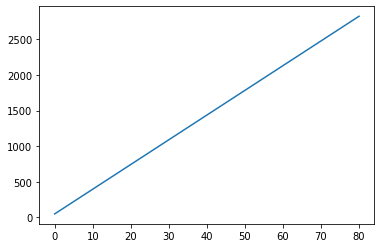

In [12]:
import matplotlib.pyplot as plt

plt.plot(mel)
plt.show()

코드3을 실행하면 `hz` 값은 그림12처럼 나옵니다. 30~7900에 이르는 주파수 구간을 81개 토막으로 자른 셈이 됩니다. 그런데 자세히 보면 토막 구간들의 길이가 일정하지 않고, 점점 길어지는 걸 확인할 수 있습니다. 예컨대 첫번째 주파수(30Hz)와 두번째 주파수(52.86Hz) 차이는 22.86입니다. 그런데 맨 마지막 직전 주파수(7638.9Hz)와 맨 마지막 주파수(7900Hz) 차이는 261.1나 됩니다. 


이렇게 불균등하게 나누는 이유는 사람의 소리 인식 특성과 관계가 있습니다. 사람은 저주파수 영역대는 세밀히 잘 인식하고, 고주파수는 상대적으로 덜 세밀히 인식하는 경향이 있다고 합니다. 우리는 모델로 하여금 말소리를 사람이 인식하는 것처럼 모사하게 만드는 데 목적이 있기 때문에 사람의 소리 인식과 비슷한 환경을 만들 필요가 있습니다. 이 때문에 low cut-off frequency $f_1$의 초기값을 **멜 스케일 기준**으로 `out_channels + 1`개 구간으로 나누는 것입니다.

## **그림12** $f_1$의 초기값

In [9]:
print(hz)

[  30.           52.85710786   76.42989706  100.74077638  125.81285623
  151.66997065  178.33669994  205.83839403  234.2011966   263.45206991
  293.61882043  324.73012529  356.81555954  389.90562424  424.03177549
  459.22645429  495.52311744  532.95626929  571.56149454  611.37549211
  652.43611001  694.7823813   738.4545612   783.49416539  829.94400943
  877.84824949  927.25242431  978.20349853 1030.74990726 1084.94160221
 1140.83009909 1198.46852666 1257.91167718 1319.21605853 1382.4399479
 1447.64344722 1514.88854026 1584.23915157 1655.76120728 1729.5226977
 1805.59374201 1884.0466549  1964.95601532 2048.39873735 2134.45414336
 2223.20403935 2314.73279281 2409.12741283 2506.47763286 2606.87599601
 2710.41794303 2817.20190298 2927.3293869  3040.90508422 3158.0369623
 3278.83636911 3403.41813904 3531.90070205 3664.40619629 3801.06058419
 3941.99377222 4087.33973432 4237.23663934 4391.82698235 4551.25772007
 4715.68041062 4885.25135758 5060.13175854 5240.48785839 5426.49110732
 5618.318

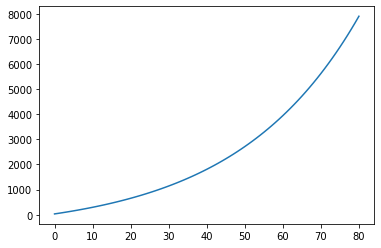

In [14]:
plt.plot(hz)
plt.show()

위에서 만든 $f_1$의 초기값들에 `torch.nn.Parameter` 함수를 적용해 learnable parameter로 만듭니다. 코드3에서 $f_1$ 초기값으로 `out_channels + 1`개를 만들어두었는데요. 코드4에선 여기에서 마지막 값을 버리고 `out_channels`개만큼만 취하는 걸 확인할 수 있습니다. `low_hz_`의 그 차원수는 (out_channels, 1)이 됩니다.

그림12의 각 요소값 간 차이(그림13 참조)만큼을 `band_hz`라는 변수로 만들고 이 또한 learnable parameter로 취급하는 걸 알 수 있습니다. `band_hz_`의 그 차원수 역시 (out_channels, 1)입니다. 이는 나중에 high cut-off frequency $f_2$를 만들 때 씁니다. 결과적으로 컨볼루션 필터(싱크 함수)의 learnable parameter는 $f_1$과 $f_2$ 두 스칼라 값뿐입니다. 한편 `low_hz_`와 `band_hz`의 초기값은 코드1에서 정의한 하이퍼파라메터를 바꾸지 않는 한 항상 같은 값으로 정해집니다.


## **코드4** learnable parameter 선언

In [19]:
low_hz_ = torch.nn.Parameter(torch.Tensor(hz[:-1]).view(-1, 1))
print(low_hz_.shape)
# print(low_hz_)
band_hz_ = torch.nn.Parameter(torch.Tensor(np.diff(hz)).view(-1, 1))
print(band_hz_.shape)
# print(band_hz_)

torch.Size([80, 1])
torch.Size([80, 1])


## **그림13** band_hz_의 초기값

In [20]:
band_hz_

Parameter containing:
tensor([[ 22.8571],
        [ 23.5728],
        [ 24.3109],
        [ 25.0721],
        [ 25.8571],
        [ 26.6667],
        [ 27.5017],
        [ 28.3628],
        [ 29.2509],
        [ 30.1667],
        [ 31.1113],
        [ 32.0854],
        [ 33.0901],
        [ 34.1262],
        [ 35.1947],
        [ 36.2967],
        [ 37.4332],
        [ 38.6052],
        [ 39.8140],
        [ 41.0606],
        [ 42.3463],
        [ 43.6722],
        [ 45.0396],
        [ 46.4498],
        [ 47.9042],
        [ 49.4042],
        [ 50.9511],
        [ 52.5464],
        [ 54.1917],
        [ 55.8885],
        [ 57.6384],
        [ 59.4431],
        [ 61.3044],
        [ 63.2239],
        [ 65.2035],
        [ 67.2451],
        [ 69.3506],
        [ 71.5221],
        [ 73.7615],
        [ 76.0710],
        [ 78.4529],
        [ 80.9094],
        [ 83.4427],
        [ 86.0554],
        [ 88.7499],
        [ 91.5288],
        [ 94.3946],
        [ 97.3502],
        [100.3984]

그림13을 조금 더 자세하게 이해해볼까요? 수식11을 보면 $f_2$는 $f_1+\|f_2-f_1\|$입니다. `band_hz_`는 나중에 $f_2-f_1$ 역할을 수행하는데요. `band_hz_` 초기값을 그림13처럼 설정해 둘 경우 첫번째 컨볼루션 필터의 $f_2$는 다음 두번째 컨볼루션 필터의 $f_1$이 됩니다. 결과적으로 목표로 하는 주파수 $f$(16000)의 절반에 해당하는 범위(7900)에서 `out_channels=80`개의 컨볼루션 필터들이 비는 주파수 영역대가 없이 촘촘하게 입력 신호를 커버한다는 이야기가 됩니다.


목표 주파수 $f$의 절반의 범위에서 입력 신호를 커버하는 것과 관련해서는 나이퀴스트 정리(Nyquist Theorem)와 관련이 있는 것 아닌가 합니다. 원 신호를 목표 주파수로 복원하기 위해서는 해당 주파수 2배 이상의 sample rate로 샘플해야 한다는 정리입니다.

자 이제는 수식12의 해밍 윈도우를 만들 차례입니다. 컨볼루션 필터(싱크 함수) 길이 $L$에 절반에 해당하는 구간에 대해서만 해밍 윈도우를 만들어 놓습니다. 해밍 윈도우는 함수 모양이 좌우 대칭(symmetric)이므로 절반만 만들어 놓고 이미 만든 절반(`window_`)과 이를 뒤집은 값들을 계산해 이어붙이면(concatnate) 같은 연산을 빠르게 수행할 수 있습니다.


## **코드5** Hamming Window

In [27]:
n_lin = torch.linspace(0, (kernel_size / 2) - 1, steps=int((kernel_size / 2)))
print(n_lin.shape)
# print(n_lin)
window_ = 0.54 - 0.46 * torch.cos(2 * math.pi * n_lin / kernel_size)
# print(window_)
# plt.plot(window_)
n = (kernel_size - 1) / 2.0
n_ = 2 * math.pi * torch.arange(-n, 0).view(1, -1) / sample_rate
print(n_.shape)

torch.Size([125])
torch.Size([1, 125])


코드5까지는 `SincConv_fast` 모듈의 `__init__` 부분에 해당하는 내용이었습니다. 다시 말해 $f_1$ 등 파라메터의 초기값이나 해밍 윈도우 같이 변하지 않는 상수 값들을 미리 만들어 두었다고 생각하면 됩니다. 코드6부터는 `forward` 부분에 해당합니다. 여기서부터는 입력 음성 신호를 받아서 태스크(화자 인식) 수행에 적절한 방향으로 $f_1$과 $f_2$를 갱신하는 파트라고 이해하면 되겠습니다.

코드6 설명의 편의를 위해 수식11을 다시 가져왔습니다. 비교해가면서 코드를 읽어봅시다. `low`, 즉 $f_1$은 앞서 만든 `low_hz_(그 초기값은 hz=그림12)`의 절대값을 취해서 만듭니다(수식11과 코드6이 다른 점은 `min_low_hz=50`을 더해준다는 점입니다). `high`, 즉 $f_2$는 $f_1+\|f_2-f_1\|$를 계산해서 만드는데요. 첫번째 항은 `low`에 대응하고요, 두번째 항은 코드4, 그림13에서 만든 `band_hz_`에 절대값을 취한 것에 대응합니다(수식11과 코드6이 다른 점은 `min_band_hz=50`을 더해준다는 점입니다). `torch.clamp` 함수는 입력이 min보다 작으면 min, max보다 크면 max, 그 사이이면 입력 그대로 리턴합니다.

한편 `band`라는 변수는 코드10을 위해 미리 준비해두는 것인데요. 싱크 함수를 대칭(symmetric)으로 만들기 위해 정의하는 것입니다. 싱크 함수는 주로 통과시키는 주파수 영역대에서 최고치를 가집니다. 이를 main lobe라고 합니다.


## **수식11** 컷오프 주파수에 대한 제약
$${ f }_{ 1 }^{ abs }=\left| { f }_{ 1 } \right| \\ { f }_{ 2 }^{ abs }={ f }_{ 1 }+\left| { f }_{ 2 }-{ f }_{ 1 } \right|$$



## **코드6** 컷오프 주파수 $f_1$과 $f_2$ 만들기

In [35]:
low = min_low_hz + torch.abs(low_hz_)
print(low.shape)
high = torch.clamp(input=low + min_band_hz + torch.abs(band_hz_),
                   min=min_low_hz,
                   max=sample_rate / 2)
print(high.shape)
band = (high - low)[:, 0]
print(band)

torch.Size([80, 1])
torch.Size([80, 1])
tensor([ 72.8571,  73.5728,  74.3109,  75.0721,  75.8571,  76.6667,  77.5017,
         78.3628,  79.2509,  80.1667,  81.1113,  82.0854,  83.0901,  84.1261,
         85.1947,  86.2966,  87.4332,  88.6052,  89.8140,  91.0606,  92.3463,
         93.6722,  95.0396,  96.4498,  97.9042,  99.4042, 100.9510, 102.5464,
        104.1917, 105.8885, 107.6384, 109.4431, 111.3044, 113.2239, 115.2035,
        117.2451, 119.3506, 121.5221, 123.7615, 126.0710, 128.4529, 130.9094,
        133.4426, 136.0554, 138.7500, 141.5288, 144.3945, 147.3501, 150.3984,
        153.5420, 156.7839, 160.1274, 163.5757, 167.1318, 170.7993, 174.5818,
        178.4827, 182.5056, 186.6543, 190.9331, 195.3462, 199.8970, 204.5903,
        209.4307, 214.4229, 219.5708, 224.8804, 230.3560, 236.0034, 241.8271,
        247.8335, 254.0278, 260.4160, 267.0044, 273.7993, 280.8066, 288.0337,
        295.4868, 303.1729, 311.1001], grad_fn=<SelectBackward0>)


코드7~8 설명의 편의를 위해 수식10을 다시 가져왔습니다. 비교해가면서 코드를 읽어봅시다. 주파수($f$)와 시간($t$), 샘플 인덱스($n$) 사이에는 다음이 성립합니다: $n=ft$. 수식10을 계산하기 위해서는 수식10의 $n$에 대응하는 값들을 만들어 두어야 하는데요. 이를 위해 코드7을 수행합니다. 다시 말해 주파수($f$)와 시간 인덱스($t$)를 곱하는 것입니다. 이를 `torch.matmul`로 수행하는 걸 코드7에서 확인할 수 있습니다.

## **수식10** 이상적인 bandpass filter - 시간 도메인
$$g\left[ n,{ f }_{ 1 },{ f }_{ 2 } \right] =2{ f }_{ 2 } \text{ sinc } \left( 2\pi { f }_{ 2 }n \right) -2{ f }_{ 1 } \text{ sinc } \left( 2\pi { f }_{ 1 }n \right)$$


## **코드7** 싱크 함수 만들기 (1)

In [36]:
f_times_t_low = torch.matmul(low, n_)   # (80,1)(1,125) => (80,125)
f_times_t_high = torch.matmul(high, n_)

In [40]:
print(f_times_t_low.shape)
print(f_times_t_low[2])

torch.Size([80, 125])
tensor([-6.2061, -6.1565, -6.1068, -6.0572, -6.0075, -5.9579, -5.9082, -5.8586,
        -5.8089, -5.7593, -5.7096, -5.6600, -5.6103, -5.5607, -5.5110, -5.4614,
        -5.4117, -5.3621, -5.3124, -5.2628, -5.2131, -5.1635, -5.1138, -5.0642,
        -5.0145, -4.9649, -4.9152, -4.8656, -4.8159, -4.7663, -4.7166, -4.6670,
        -4.6173, -4.5677, -4.5181, -4.4684, -4.4188, -4.3691, -4.3195, -4.2698,
        -4.2202, -4.1705, -4.1209, -4.0712, -4.0216, -3.9719, -3.9223, -3.8726,
        -3.8230, -3.7733, -3.7237, -3.6740, -3.6244, -3.5747, -3.5251, -3.4754,
        -3.4258, -3.3761, -3.3265, -3.2768, -3.2272, -3.1775, -3.1279, -3.0782,
        -3.0286, -2.9789, -2.9293, -2.8796, -2.8300, -2.7803, -2.7307, -2.6810,
        -2.6314, -2.5817, -2.5321, -2.4824, -2.4328, -2.3831, -2.3335, -2.2838,
        -2.2342, -2.1846, -2.1349, -2.0853, -2.0356, -1.9860, -1.9363, -1.8867,
        -1.8370, -1.7874, -1.7377, -1.6881, -1.6384, -1.5888, -1.5391, -1.4895,
        -1.4398, -

코드7에서 `low`와 `high`는 지금까지 주파수로 정의해 왔기 때문에 이해가 그리 어렵지 않을 것 같은데요. `n_`은 대체 어디에서 튀어나왔는지 감을 잡기 어렵습니다. 이는 코드5에 힌트가 있습니다. 코드8은 코드5에서 `n_`과 관련한 부분을 발췌해 가져온 것입니다.


## **코드8** n_

In [44]:
print(torch.arange(-n, 0).view(1, -1))

tensor([[-125., -124., -123., -122., -121., -120., -119., -118., -117., -116.,
         -115., -114., -113., -112., -111., -110., -109., -108., -107., -106.,
         -105., -104., -103., -102., -101., -100.,  -99.,  -98.,  -97.,  -96.,
          -95.,  -94.,  -93.,  -92.,  -91.,  -90.,  -89.,  -88.,  -87.,  -86.,
          -85.,  -84.,  -83.,  -82.,  -81.,  -80.,  -79.,  -78.,  -77.,  -76.,
          -75.,  -74.,  -73.,  -72.,  -71.,  -70.,  -69.,  -68.,  -67.,  -66.,
          -65.,  -64.,  -63.,  -62.,  -61.,  -60.,  -59.,  -58.,  -57.,  -56.,
          -55.,  -54.,  -53.,  -52.,  -51.,  -50.,  -49.,  -48.,  -47.,  -46.,
          -45.,  -44.,  -43.,  -42.,  -41.,  -40.,  -39.,  -38.,  -37.,  -36.,
          -35.,  -34.,  -33.,  -32.,  -31.,  -30.,  -29.,  -28.,  -27.,  -26.,
          -25.,  -24.,  -23.,  -22.,  -21.,  -20.,  -19.,  -18.,  -17.,  -16.,
          -15.,  -14.,  -13.,  -12.,  -11.,  -10.,   -9.,   -8.,   -7.,   -6.,
           -5.,   -4.,   -3.,   -2.,   -1.]])


In [41]:
n = (kernel_size - 1) / 2.0
n_ = 2 * math.pi * torch.arange(-n, 0).view(1, -1) / sample_rate

`torch.arange(-n, 0).view(1, -1)`를 수행한 결과는 그림14와 같습니다. 이는 시간 인덱스($t$)에 대응합니다. 이 벡터에 `low`, `high`를 내적한 결과가 수식10 싱크 함수 내부에 있는 각각의 $n$이 됩니다. 그런데 코드8을 보면 $2\pi$를 곱하고 $f$, 즉 `sample_rate`로 나눠준걸 볼 수 있습니다. 전자인 $2\pi$는 수식10의 싱크 함수 내에 있는 $2\pi$에 대응합니다.

## **그림14** 시간 인덱스 만들기

In [42]:
n_

tensor([[-0.0491, -0.0487, -0.0483, -0.0479, -0.0475, -0.0471, -0.0467, -0.0463,
         -0.0459, -0.0456, -0.0452, -0.0448, -0.0444, -0.0440, -0.0436, -0.0432,
         -0.0428, -0.0424, -0.0420, -0.0416, -0.0412, -0.0408, -0.0404, -0.0401,
         -0.0397, -0.0393, -0.0389, -0.0385, -0.0381, -0.0377, -0.0373, -0.0369,
         -0.0365, -0.0361, -0.0357, -0.0353, -0.0350, -0.0346, -0.0342, -0.0338,
         -0.0334, -0.0330, -0.0326, -0.0322, -0.0318, -0.0314, -0.0310, -0.0306,
         -0.0302, -0.0298, -0.0295, -0.0291, -0.0287, -0.0283, -0.0279, -0.0275,
         -0.0271, -0.0267, -0.0263, -0.0259, -0.0255, -0.0251, -0.0247, -0.0243,
         -0.0240, -0.0236, -0.0232, -0.0228, -0.0224, -0.0220, -0.0216, -0.0212,
         -0.0208, -0.0204, -0.0200, -0.0196, -0.0192, -0.0188, -0.0185, -0.0181,
         -0.0177, -0.0173, -0.0169, -0.0165, -0.0161, -0.0157, -0.0153, -0.0149,
         -0.0145, -0.0141, -0.0137, -0.0134, -0.0130, -0.0126, -0.0122, -0.0118,
         -0.0114, -0.0110, -

싱크 함수가 $sinc(x)=sin(x)/x$ 꼴인 사실을 상기해보면 코드8을 이해할 수 있습니다. 다시 말해 $2f_2 \text{sinc}(2\pi f_2n)=2 f_2 \times \sin(2\pi f_2 n) / 2\pi f_2 n=\sin(2\pi f_2 n) / \pi n$이므로, 시간 인덱스에 $2\pi$가 이미 곱해진 `n_`에 2로 나눈 값을 다시 나눠주면 수식10이 된다는 것입니다. 여기에 코드5의 해밍 윈도우를 곱합니다.

여지껏 계산한 내용이 컨볼루션 필터(싱크 함수)의 좌측 부분, 즉 `band_pass_left`입니다. 우리는 좌우 대칭(symmetric)인 싱크 함수를 만들고 있으므로 이를 뒤집어(torch.flip) 오른쪽 부분 `band_pass_right`을 만들고 중간값(`band_pass_center`) 역시 만듭니다. 최종적으로는 이를 이어붙여(concatenate) 필터 계산을 마칩니다.


## **코드8** 싱크 함수 만들기 (2)

In [45]:
band_pass_left = ((torch.sin(f_times_t_high) - torch.sin(f_times_t_low)) / (n_ / 2)) * window_
band_pass_center = 2 * band.view(-1, 1)
band_pass_right = torch.flip(band_pass_left, dims=[1])
band_pass = torch.cat([band_pass_left, band_pass_center, band_pass_right], dim=1)
band_pass = band_pass / (2 * band[:, None])
filters = (band_pass).view(out_channels, 1, kernel_size)

torch.Size([80, 1, 251])


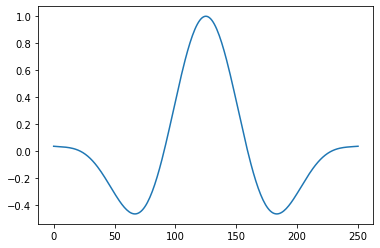

In [54]:
print(filters.shape)
# print(filters[0][0])
plt.plot(filters[0][0].detach().numpy())


이렇게 만든 필터들은 그림15처럼 생겼습니다(초기값 기준).

## **그림15** 컨볼루션 필터들의 초기 모습

In [53]:
filters

tensor([[[ 0.0368,  0.0362,  0.0356,  ...,  0.0356,  0.0362,  0.0368]],

        [[ 0.0362,  0.0380,  0.0397,  ...,  0.0397,  0.0380,  0.0362]],

        [[-0.0074, -0.0048, -0.0021,  ..., -0.0021, -0.0048, -0.0074]],

        ...,

        [[-0.0043,  0.0060, -0.0072,  ..., -0.0072,  0.0060, -0.0043]],

        [[-0.0016,  0.0031, -0.0044,  ..., -0.0044,  0.0031, -0.0016]],

        [[-0.0022,  0.0028, -0.0034,  ..., -0.0034,  0.0028, -0.0022]]],
       grad_fn=<ViewBackward0>)

이 필터들을 입력 음성 신호에 대한 1D 컨볼루션 연산에 사용합니다. 태스크 학습 과정에서 역전파(backpropagation)되어 전달된 그래디언트(gradient)를 받아 $f_1$과 $f_2$를 학습합니다. 컨볼루션 필터 수(`out_channels`)가 80일 경우 총 160개의 스칼라값이 SincNet 첫번째 레이어의 학습 대상 파라메터가 됩니다. 


## **코드9** 1D 컨볼루션 연산

In [59]:
x = torch.tensor([[[1,2,3,4,5,6]]]) # (1,1,6)
f = torch.tensor([[[1,0,2]]]) # (1,1,3)
result = F.conv1d(x, f)
print(result)

tensor([[[ 7, 10, 13, 16]]])


In [61]:
waveforms = torch.rand(1,1,sample_rate*2)
print(waveforms.shape)

torch.Size([1, 1, 32000])


In [63]:
# 이후 이 80개 필터들이 각각 입력 raw wave에 대해 1d conv 실시
sincnet_result = F.conv1d(waveforms, filters, stride=stride,
                          padding=padding, dilation=dilation,
                          bias=None, groups=1)   # (1,1,32000)(80,1,251) => (1,80,31750)
print(sincnet_result.shape)

torch.Size([1, 80, 31750])


## Experiment

SincNet 저자들은 화자 인식 태스크에 이 모델을 적용했습니다. 그림16의 우측(TIMIT 데이터셋)을 보면 기존 CNN 대비 수렴이 빠른 점을 확인할 수 있습니다. 그림16의 좌측을 보면 SincNet 필터들이 기존 CNN 필터들 대비 중요 음성 특질 중 하나인 포만트(Formant) 주파수를 잘 잡아내고, 나머지 불필요한 주파수 영역대는 확실히 무시하는 점을 볼 수 있습니다.


## **그림16** SincNet 실험 결과 (1)
<img src="https://i.imgur.com/yZzkEXA.png" width="400px" title="source: imgur.com" />


그림17은 Librispeech 데이터셋을 학습한 결과입니다. 첫번째 행은 시간 도메인, 두번째 행은 주파수 도메인에 대응합니다. SincNet 필터들이 이상적인 형태의 bandpass filter 모양에 가까운 걸 확인할 수 있습니다. 즉 low/high cut-off frequency를 학습해 해당 주파수 영역대 정보를 잘 캐치하고 나머지 영역대를 무시한다는 이야기입니다. 저자들은 SincNet 성능과 해석력(interpretability)이 기존 CNN 대비 좋다고 강조하고 있습니다.


## **그림17** SincNet 실험 결과 (2)
<img src="https://i.imgur.com/E8jQx5p.png" width="400px" title="source: imgur.com" />


---


## References


- [Ravanelli, M., & Bengio, Y. (2018). Speech and speaker recognition from raw waveform with sincnet. arXiv preprint arXiv:1812.05920.](https://arxiv.org/pdf/1812.05920)

---